In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1),  # 1*3*3*4 + 4 = 40 params
            nn.ReLU(),
            nn.BatchNorm2d(4),              # 8 params
            nn.Conv2d(4, 4, 3, padding=1),  # 4*3*3*4 + 4 = 148 params
            nn.ReLU(),
            nn.BatchNorm2d(4),              # 8 params
            nn.MaxPool2d(2, 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, 3, padding=1),  # 4*3*3*8 + 8 = 296 params
            nn.ReLU(),
            nn.BatchNorm2d(8),              # 16 params
            nn.Conv2d(8, 8, 3, padding=1),  # 8*3*3*8 + 8 = 584 params
            nn.ReLU(),
            nn.BatchNorm2d(8),              # 16 params
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 12, 3, padding=1), # 8*3*3*12 + 12 = 876 params
            nn.ReLU(),
            nn.BatchNorm2d(12),             # 24 params
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        
        # 12 channels * 3 * 3 = 108 neurons after three max pools (28->14->7->3)
        self.fc1 = nn.Linear(12 * 3 * 3, 10)  # 108*10 + 10 = 1090 params
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 12 * 3 * 3)  # Flatten
        x = F.dropout(x, p=0.1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


In [3]:
#!pip install torchinfo
from torchinfo import summary
use_cuda = torch.cuda.is_available()
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if use_cuda else "cpu")
model = Net().to(device)
# Create a dummy input tensor on the correct device
summary(model, input_size=(1, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 28, 28]            8
│    └─Conv2d: 2-4                       [1, 4, 28, 28]            148
│    └─ReLU: 2-5                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-6                  [1, 4, 28, 28]            8
│    └─MaxPool2d: 2-7                    [1, 4, 14, 14]            --
├─Sequential: 1-2                        [1, 8, 7, 7]              --
│    └─Conv2d: 2-8                       [1, 8, 14, 14]            296
│    └─ReLU: 2-9                         [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-10                 [1, 8, 14, 14]            16
│    └─Conv2d: 

In [4]:


torch.manual_seed(1456)
batch_size = 512

kwargs = {'num_workers': 0, 'pin_memory': True} if device.type in ["cuda", "mps"] else {}
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                     transform=transforms.Compose([
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.1307,), (0.3081,))
#                     ])),
#     batch_size=batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.Compose([
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.1307,), (0.3081,))
#                     ])),
#     batch_size=batch_size, shuffle=True, **kwargs)


import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import random
# Define the augmentation pipeline
train_transforms = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.0625,
        scale_limit=0.1,
        rotate_limit=15,
        p=0.7,
        border_mode=cv2.BORDER_CONSTANT,
        value=0
    ),
    A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.3),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.3),
    A.Perspective(scale=(0.05, 0.1), p=0.3, keep_size=True, pad_mode=cv2.BORDER_CONSTANT, pad_val=0),

    A.ElasticTransform(
         alpha=1.0,
         sigma=10.0,
         alpha_affine=None,  # Set to None as required by newer versions
         interpolation=cv2.INTER_LINEAR,
         border_mode=cv2.BORDER_CONSTANT,
         value=0,
         p=0.3
    ),
    
    # CoarseDropout as alternative to regular dropout
    A.CoarseDropout(
        max_holes=2,
        max_height=8,
        max_width=8,
        min_holes=1,
        fill_value=0,
        p=0.2
    ),

    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])

# Custom Dataset class to work with Albumentations
class MNISTAlbumentations(datasets.MNIST):
    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root, train=train, download=download, transform=None)
        self.transform = transform
        
    def __getitem__(self, idx):
        img, label = self.data[idx], self.targets[idx]
        
        # Convert to numpy array and add channel dimension
        img = np.array(img)
        img = np.expand_dims(img, axis=-1)  # Add channel dimension for Albumentations
        
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed["image"]
            
        return img, label


# Update the data loaders
train_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=True, download=True, transform=train_transforms),
    batch_size=batch_size, shuffle=True, 
    **kwargs)

# Test transforms (only normalization, no augmentation)
test_transforms = A.Compose([
    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])

test_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=False, transform=test_transforms),
    batch_size=batch_size, shuffle=True,  
    **kwargs)

# Optional: Visualization function to check augmentations
def visualize_augmentations(dataset, idx=0, samples=5):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20, 4))
    for i in range(samples):
        data = dataset[idx][0]
        if isinstance(data, torch.Tensor):
            data = data.numpy()
        if data.shape[0] == 1:  # If channels first, move to last
            data = np.transpose(data, (1, 2, 0))
        plt.subplot(1, samples, i + 1)
        plt.imshow(data.squeeze(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()



/Users/dhairyashil/miniconda3/envs/erav2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/dhairyashil/miniconda3/envs/erav2/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


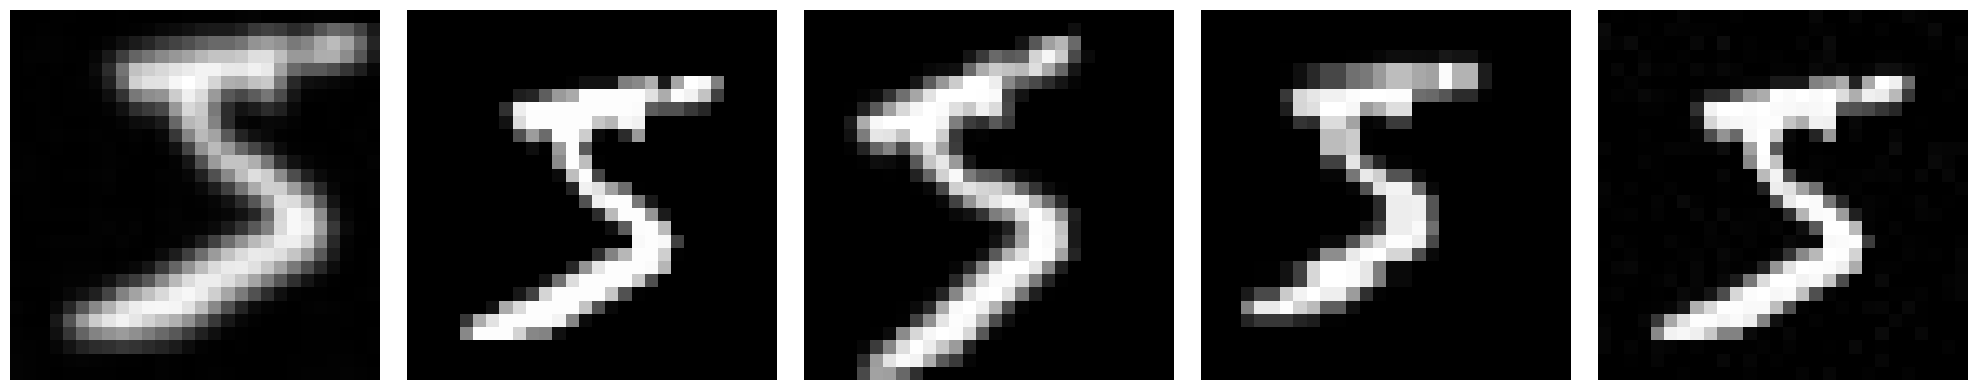

Number of samples in train dataset: 60000
Number of samples in test dataset: 10000


In [5]:
# Uncomment to visualize augmentations
visualize_augmentations(train_loader.dataset)

# # print number of samples in train and test dataset
print(f"Number of samples in train dataset: {len(train_loader.dataset)}")
print(f"Number of samples in test dataset: {len(test_loader.dataset)}")


In [6]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 14):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)



loss=0.5153403282165527 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s] 



Test set: Average loss: 0.1595, Accuracy: 9519/10000 (95.19%)



loss=0.44261348247528076 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s]



Test set: Average loss: 0.1099, Accuracy: 9668/10000 (96.68%)



loss=0.22794997692108154 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s]



Test set: Average loss: 0.0926, Accuracy: 9709/10000 (97.09%)



loss=0.3529849052429199 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s] 



Test set: Average loss: 0.0947, Accuracy: 9718/10000 (97.18%)



loss=0.295000821352005 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]  



Test set: Average loss: 0.0822, Accuracy: 9754/10000 (97.54%)



loss=0.37374138832092285 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]



Test set: Average loss: 0.0662, Accuracy: 9806/10000 (98.06%)



loss=0.26952099800109863 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s]



Test set: Average loss: 0.0702, Accuracy: 9777/10000 (97.77%)



loss=0.1477661281824112 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s] 



Test set: Average loss: 0.0733, Accuracy: 9769/10000 (97.69%)



loss=0.25704240798950195 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s]



Test set: Average loss: 0.0597, Accuracy: 9805/10000 (98.05%)



loss=0.1488422006368637 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s] 



Test set: Average loss: 0.0600, Accuracy: 9816/10000 (98.16%)



loss=0.1876668930053711 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s] 



Test set: Average loss: 0.0517, Accuracy: 9838/10000 (98.38%)



loss=0.22511929273605347 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s]



Test set: Average loss: 0.0620, Accuracy: 9814/10000 (98.14%)



loss=0.40174010396003723 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.57it/s]



Test set: Average loss: 0.0540, Accuracy: 9825/10000 (98.25%)



In [8]:

model = Net().to(device)
from torch.optim.swa_utils import AveragedModel, SWALR

swa_model = AveragedModel(model)

# Use OneCycleLR scheduler for better convergence
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.4,
    epochs=15,                          # Increased epochs
    steps_per_epoch=len(train_loader),
    pct_start=0.3,                      # Warm up for 30% of training
    div_factor=10,                      # Initial lr = max_lr/10
    final_div_factor=100                # Final lr = initial_lr/100
)

# Start SWA later in training
swa_start = 5
swa_scheduler = SWALR(optimizer, swa_lr=0.001)

for epoch in range(1, 15):  # Increased to 20 epochs
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate: {current_lr:.6f}')
    
    if epoch < swa_start:
        train(model, device, train_loader, optimizer, epoch, scheduler)
    else:
        train(model, device, train_loader, optimizer, epoch)
        swa_model.update_parameters(model)
        swa_scheduler.step()
    
    test(model, device, test_loader)
    
    if epoch >= swa_start:
        torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)
        test(swa_model, device, test_loader)
    


Current learning rate: 0.040000


loss=0.3176345229148865 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s] 



Test set: Average loss: 0.1173, Accuracy: 9640/10000 (96.40%)

Current learning rate: 0.082265


loss=0.3383333683013916 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s] 



Test set: Average loss: 0.0905, Accuracy: 9725/10000 (97.25%)

Current learning rate: 0.189210


loss=0.13150779902935028 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s]



Test set: Average loss: 0.0722, Accuracy: 9764/10000 (97.64%)

Current learning rate: 0.310615


loss=0.22246579825878143 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]



Test set: Average loss: 0.0623, Accuracy: 9796/10000 (97.96%)

Current learning rate: 0.389467


loss=0.22129005193710327 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.62it/s]



Test set: Average loss: 0.0523, Accuracy: 9836/10000 (98.36%)


Test set: Average loss: 0.0530, Accuracy: 9830/10000 (98.30%)

Current learning rate: 0.379960


loss=0.11158696562051773 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s]



Test set: Average loss: 0.0535, Accuracy: 9814/10000 (98.14%)


Test set: Average loss: 0.0393, Accuracy: 9869/10000 (98.69%)

Current learning rate: 0.352371


loss=0.20513562858104706 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.67it/s]



Test set: Average loss: 0.0491, Accuracy: 9852/10000 (98.52%)


Test set: Average loss: 0.0386, Accuracy: 9880/10000 (98.80%)

Current learning rate: 0.309401


loss=0.2614821791648865 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s] 



Test set: Average loss: 0.0510, Accuracy: 9832/10000 (98.32%)


Test set: Average loss: 0.0367, Accuracy: 9879/10000 (98.79%)

Current learning rate: 0.255255


loss=0.13497264683246613 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]



Test set: Average loss: 0.0409, Accuracy: 9867/10000 (98.67%)


Test set: Average loss: 0.0342, Accuracy: 9892/10000 (98.92%)

Current learning rate: 0.195233


loss=0.39012646675109863 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]



Test set: Average loss: 0.0461, Accuracy: 9858/10000 (98.58%)


Test set: Average loss: 0.0341, Accuracy: 9895/10000 (98.95%)

Current learning rate: 0.135212


loss=0.13719280064105988 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]



Test set: Average loss: 0.0414, Accuracy: 9878/10000 (98.78%)


Test set: Average loss: 0.0335, Accuracy: 9890/10000 (98.90%)

Current learning rate: 0.081066


loss=0.17263805866241455 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]



Test set: Average loss: 0.0405, Accuracy: 9872/10000 (98.72%)


Test set: Average loss: 0.0336, Accuracy: 9895/10000 (98.95%)

Current learning rate: 0.038095


loss=0.1456877738237381 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.64it/s] 



Test set: Average loss: 0.0381, Accuracy: 9880/10000 (98.80%)


Test set: Average loss: 0.0347, Accuracy: 9886/10000 (98.86%)

Current learning rate: 0.010506


loss=0.1492350548505783 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.61it/s] 



Test set: Average loss: 0.0357, Accuracy: 9884/10000 (98.84%)


Test set: Average loss: 0.0329, Accuracy: 9904/10000 (99.04%)



In [9]:

model = Net().to(device)
from torch.optim.swa_utils import AveragedModel, SWALR

swa_model = AveragedModel(model)

# Use OneCycleLR scheduler for better convergence
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.4,
    epochs=10,                          # Increased epochs
    steps_per_epoch=len(train_loader),
    pct_start=0.3,                      # Warm up for 30% of training
    div_factor=10,                      # Initial lr = max_lr/10
    final_div_factor=10000                # Final lr = initial_lr/100
)

# Start SWA later in training
swa_start = 5
swa_scheduler = SWALR(optimizer, swa_lr=0.001)

for epoch in range(1, 11):  # Increased to 20 epochs
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate: {current_lr:.6f}')
    
    train(model, device, train_loader, optimizer, epoch, scheduler)
    if epoch >= swa_start:
        swa_model.update_parameters(model)
        #swa_scheduler.step()
    
    test(model, device, test_loader)
    
    if epoch >= swa_start:
        torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)
        test(swa_model, device, test_loader)
    

Current learning rate: 0.040000


  0%|          | 0/118 [00:00<?, ?it/s]

loss=0.3494378626346588 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s] 



Test set: Average loss: 0.1121, Accuracy: 9665/10000 (96.65%)

Current learning rate: 0.130463


loss=0.24423645436763763 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]



Test set: Average loss: 0.1120, Accuracy: 9667/10000 (96.67%)

Current learning rate: 0.310923


loss=0.30810320377349854 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.73it/s]



Test set: Average loss: 0.0741, Accuracy: 9769/10000 (97.69%)

Current learning rate: 0.399999


loss=0.24381078779697418 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.74it/s]



Test set: Average loss: 0.0608, Accuracy: 9802/10000 (98.02%)

Current learning rate: 0.379863


loss=0.225237175822258 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.64it/s]  



Test set: Average loss: 0.0560, Accuracy: 9837/10000 (98.37%)


Test set: Average loss: 0.0538, Accuracy: 9838/10000 (98.38%)

Current learning rate: 0.324103


loss=0.21478641033172607 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s]



Test set: Average loss: 0.0600, Accuracy: 9817/10000 (98.17%)


Test set: Average loss: 0.0459, Accuracy: 9863/10000 (98.63%)

Current learning rate: 0.243764


loss=0.15717071294784546 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s]



Test set: Average loss: 0.0400, Accuracy: 9870/10000 (98.70%)


Test set: Average loss: 0.0425, Accuracy: 9862/10000 (98.62%)

Current learning rate: 0.154757


loss=0.2991573214530945 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.67it/s] 



Test set: Average loss: 0.0398, Accuracy: 9880/10000 (98.80%)


Test set: Average loss: 0.0391, Accuracy: 9884/10000 (98.84%)

Current learning rate: 0.074711


loss=0.08748733252286911 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s]



Test set: Average loss: 0.0412, Accuracy: 9879/10000 (98.79%)


Test set: Average loss: 0.0417, Accuracy: 9864/10000 (98.64%)

Current learning rate: 0.019481


loss=0.1466939002275467 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s] 



Test set: Average loss: 0.0412, Accuracy: 9870/10000 (98.70%)


Test set: Average loss: 0.0406, Accuracy: 9880/10000 (98.80%)



In [10]:
model = Net().to(device)
swa_model = AveragedModel(model)

# Modified optimizer and scheduler settings
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.2,                         # Reduced max_lr for more stability
    epochs=15,                          # Increased epochs
    steps_per_epoch=len(train_loader),
    pct_start=0.3,                      
    div_factor=25,                      # Initial lr = max_lr/25 = 0.008
    final_div_factor=1e4                # Final lr = initial_lr/10000 ≈ 8e-7
)

# Start SWA later in training
swa_start = 8                           # Start SWA later to let OneCycleLR work longer
swa_scheduler = SWALR(optimizer, swa_lr=0.0001)  # Reduced SWA learning rate

for epoch in range(1, 16):
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current learning rate: {current_lr:.6f}')
    
    if epoch < swa_start:
        train(model, device, train_loader, optimizer, epoch, scheduler)
    else:
        # After SWA starts, use a very small constant learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.001
        train(model, device, train_loader, optimizer, epoch)
        swa_model.update_parameters(model)
    
    test(model, device, test_loader)
    
    if epoch >= swa_start:
        torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)
        test(swa_model, device, test_loader)

Current learning rate: 0.008000


loss=0.44018951058387756 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s]



Test set: Average loss: 0.1245, Accuracy: 9621/10000 (96.21%)

Current learning rate: 0.030541


loss=0.32167598605155945 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s]



Test set: Average loss: 0.0738, Accuracy: 9780/10000 (97.80%)

Current learning rate: 0.087579


loss=0.31309664249420166 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]



Test set: Average loss: 0.0822, Accuracy: 9749/10000 (97.49%)

Current learning rate: 0.152328


loss=0.10911029577255249 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]



Test set: Average loss: 0.0578, Accuracy: 9802/10000 (98.02%)

Current learning rate: 0.194382


loss=0.19831985235214233 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]



Test set: Average loss: 0.0693, Accuracy: 9787/10000 (97.87%)

Current learning rate: 0.198845


loss=0.3008888065814972 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s] 



Test set: Average loss: 0.0596, Accuracy: 9797/10000 (97.97%)

Current learning rate: 0.189987


loss=0.22673659026622772 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]



Test set: Average loss: 0.0403, Accuracy: 9868/10000 (98.68%)

Current learning rate: 0.173133


loss=0.20961563289165497 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.73it/s]



Test set: Average loss: 0.0390, Accuracy: 9873/10000 (98.73%)


Test set: Average loss: 0.0386, Accuracy: 9874/10000 (98.74%)

Current learning rate: 0.000100


loss=0.30503180623054504 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s]



Test set: Average loss: 0.0392, Accuracy: 9880/10000 (98.80%)


Test set: Average loss: 0.0365, Accuracy: 9881/10000 (98.81%)

Current learning rate: 0.000100


loss=0.15647047758102417 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]



Test set: Average loss: 0.0394, Accuracy: 9874/10000 (98.74%)


Test set: Average loss: 0.0391, Accuracy: 9882/10000 (98.82%)

Current learning rate: 0.000100


loss=0.15107975900173187 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s]



Test set: Average loss: 0.0383, Accuracy: 9873/10000 (98.73%)


Test set: Average loss: 0.0407, Accuracy: 9871/10000 (98.71%)

Current learning rate: 0.000100


loss=0.12172702699899673 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s]



Test set: Average loss: 0.0387, Accuracy: 9876/10000 (98.76%)


Test set: Average loss: 0.0386, Accuracy: 9886/10000 (98.86%)

Current learning rate: 0.000100


loss=0.056091148406267166 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]



Test set: Average loss: 0.0390, Accuracy: 9867/10000 (98.67%)


Test set: Average loss: 0.0387, Accuracy: 9879/10000 (98.79%)

Current learning rate: 0.000100


loss=0.1886254996061325 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s] 



Test set: Average loss: 0.0386, Accuracy: 9874/10000 (98.74%)


Test set: Average loss: 0.0384, Accuracy: 9873/10000 (98.73%)

Current learning rate: 0.000100


loss=0.13730067014694214 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s]



Test set: Average loss: 0.0368, Accuracy: 9881/10000 (98.81%)


Test set: Average loss: 0.0389, Accuracy: 9881/10000 (98.81%)

